In [68]:
import os
import lime
import lime.lime_tabular
import Loader
import numpy as np
from mne import viz
from scipy import io, stats
from matplotlib import colors, pyplot as plt
from sklearn import preprocessing, model_selection, ensemble, neural_network

In [2]:
CAF_DOSE = 200

PROJECT_PATH = 'E:\\Cafeine_data'

STAGES = ['AWA', 'N1', 'N2', 'N3', 'REM']
BANDS = ['delta', 'theta', 'alpha', 'sigma', 'beta', 'low gamma']

In [3]:
sensor_pos = io.loadmat(os.path.join(PROJECT_PATH, 'Coo_caf'))['Cor'].T
sensor_pos = np.array([sensor_pos[1], sensor_pos[0]]).T

In [4]:
subject_labels = Loader.load_labels(CAF_DOSE)

psd = Loader.load_feature('PSD', CAF_DOSE)

features = [(psd, 120)]

In [5]:
data, labels = Loader.prepare_features(features, subject_labels)

In [6]:
feature_names = []

for electrode in range(20):
    for frequency in range(6):
        feature_names.append(f'e{electrode} {BANDS[frequency]}')

In [7]:
x_train, x_test, y_train, y_test = {}, {}, {}, {}
for stage in STAGES:
    split = model_selection.train_test_split(data[stage], labels[stage], test_size=0.2, shuffle=True)
    x_train[stage], x_test[stage], y_train[stage], y_test[stage] = split

    scaler = preprocessing.StandardScaler()
    scaler.fit(x_train[stage])

    x_train[stage] = scaler.transform(x_train[stage])
    x_test[stage] = scaler.transform(x_test[stage])

# Random Forest

In [8]:
rfs = {}
for stage in STAGES:
    print(f'Training random forest on sleep stage {stage}...')
    rfs[stage] = ensemble.RandomForestClassifier(n_estimators=200)
    rfs[stage].fit(x_train[stage], y_train[stage])

Training random forest on sleep stage AWA...
Training random forest on sleep stage N1...
Training random forest on sleep stage N2...
Training random forest on sleep stage N3...
Training random forest on sleep stage REM...


In [94]:
for stage in STAGES:
    acc_train = rfs[stage].score(x_train[stage], y_train[stage]) * 100
    acc_test = rfs[stage].score(x_test[stage], y_test[stage]) * 100
    print(f'{stage} stage accuracy for training data: {acc_train:.3f}%, testing data: {acc_test:.3f}%')

AWA stage accuracy for training data: 100.000%, testing data: 84.881%
N1 stage accuracy for training data: 100.000%, testing data: 75.020%
N2 stage accuracy for training data: 100.000%, testing data: 87.198%
N3 stage accuracy for training data: 100.000%, testing data: 85.998%
REM stage accuracy for training data: 100.000%, testing data: 86.560%


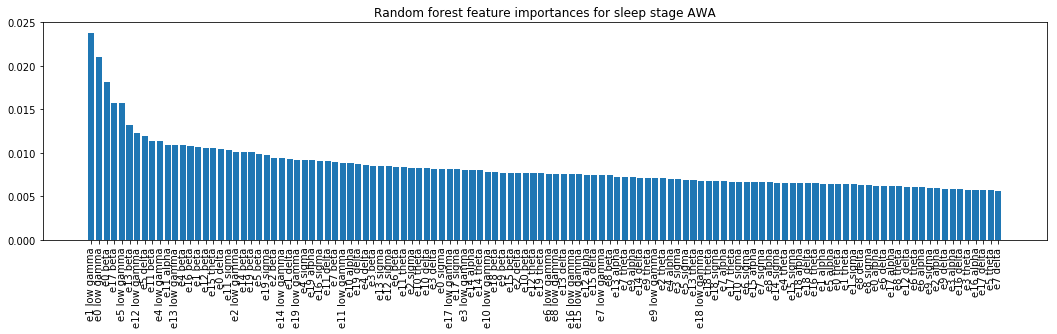

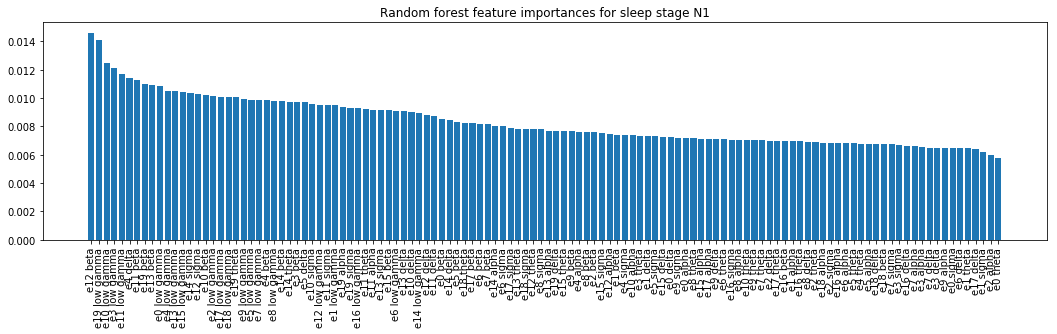

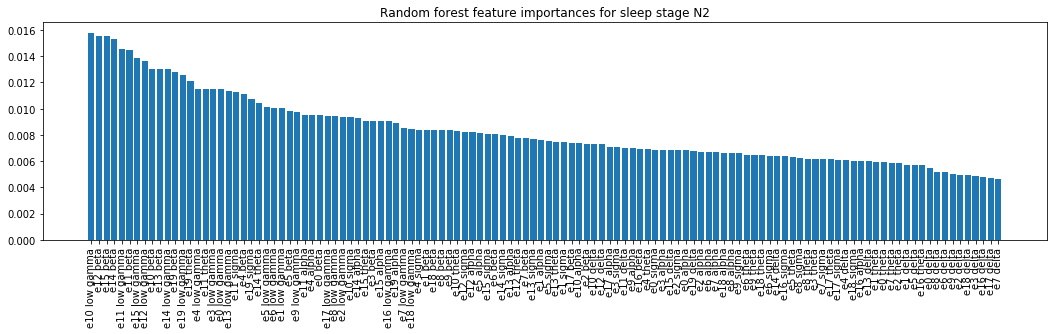

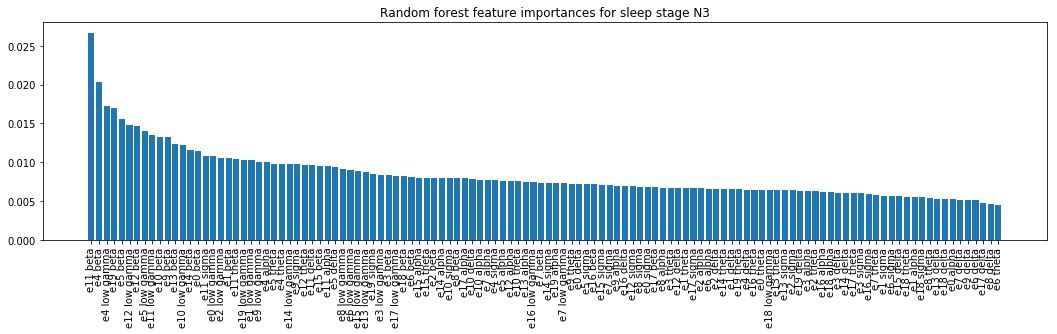

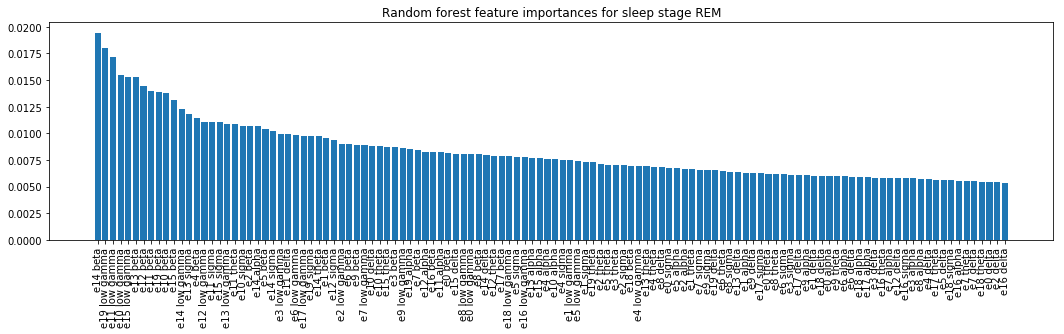

In [10]:
for stage in STAGES:
    indices = np.argsort(rfs[stage].feature_importances_)[::-1]
    
    plt.figure(figsize=(18, 4))
    plt.title(f'Random forest feature importances for sleep stage {stage}')
    plt.bar(np.arange(len(indices)), rfs[stage].feature_importances_[indices])
    plt.xticks(np.arange(len(indices)), np.array(feature_names)[indices], rotation=90)
    plt.show()

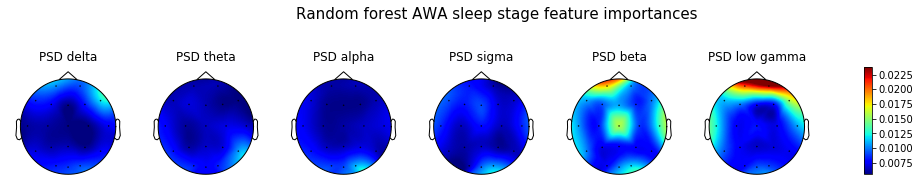

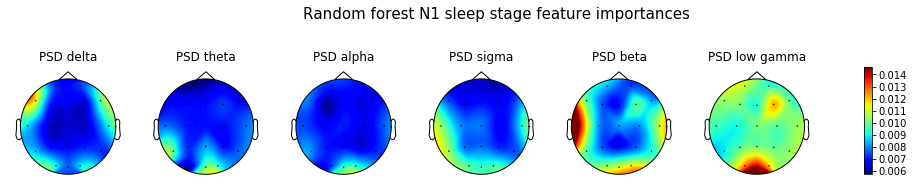

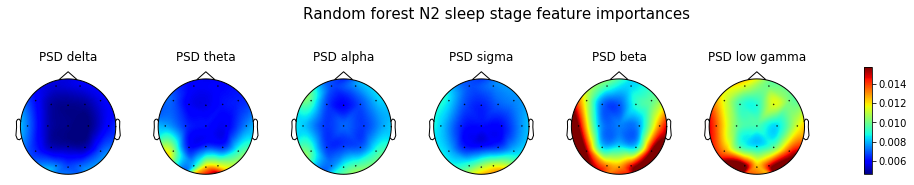

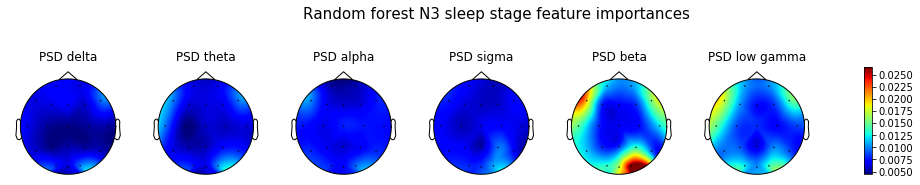

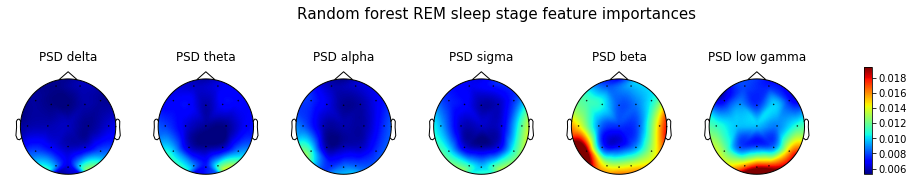

In [95]:
importances = dict([(stage, rfs[stage].feature_importances_) for stage in STAGES])

colormap = 'jet'

for stage in STAGES:
    plt.figure(figsize=(18, 6))
    plt.suptitle(f'Random forest {stage} sleep stage feature importances', y=0.8, fontsize=15)

    vmin = importances[stage].min()
    vmax = importances[stage].max()
    
    axes = []
    for i, band in enumerate(BANDS):
        importance = importances[stage][i::6]
        
        ax = plt.subplot(1, len(BANDS), i + 1)
        axes.append(ax)
        plt.title(f'PSD {band}')
        viz.plot_topomap(importance, sensor_pos, cmap=colormap, vmin=vmin, vmax=vmax, contours=False, show=False)
    
    norm = colors.Normalize(vmin=vmin,vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=axes, shrink=0.3, aspect=15)
    plt.show()

# Multilayer Perceptron

In [13]:
mlps = {}
for stage in STAGES:
    print(f'Training multilayer perceptron on sleep stage {stage}...')
    mlps[stage] = neural_network.MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=750)
    mlps[stage].fit(x_train[stage], y_train[stage])

Training multilayer perceptron on sleep stage AWA...
Training multilayer perceptron on sleep stage N1...
Training multilayer perceptron on sleep stage N2...
Training multilayer perceptron on sleep stage N3...
Training multilayer perceptron on sleep stage REM...


In [14]:
for stage in STAGES:
    acc_train = mlps[stage].score(x_train[stage], y_train[stage]) * 100
    acc_test = mlps[stage].score(x_test[stage], y_test[stage]) * 100
    print(f'{stage} stage accuracy for training data: {acc_train:.3f}%, testing data: {acc_test:.3f}%')

AWA stage accuracy for training data: 98.206%, testing data: 89.216%
N1 stage accuracy for training data: 98.856%, testing data: 79.669%
N2 stage accuracy for training data: 99.447%, testing data: 95.362%
N3 stage accuracy for training data: 100.000%, testing data: 91.698%
REM stage accuracy for training data: 99.780%, testing data: 91.781%


In [63]:
total = 400

explainer = lime.lime_tabular.LimeTabularExplainer(x_train['REM'], feature_names=feature_names, class_names=['PLAC', 'CAF'], discretize_continuous=True)

importances = {
    0: np.empty((0, 120)),
    1: np.empty((0, 120))
}

for num in range(total):
    print(f'Calculating LIME feature importances {(num + 1) / total * 100:.2f}%', end='\r')
    i = np.random.randint(0, x_test['REM'].shape[0])
    exp = explainer.explain_instance(x_test['REM'][i], mlps['REM'].predict_proba, num_features=120)
    
    correct = y_test['REM'][i]
    
    indices = [ft[0] for ft in exp.as_map()[1]]
    curr = np.array([np.array([ft[1] for ft in exp.as_map()[1]])[indices]])
    importances[correct] = np.append(importances[correct], curr, axis=0)

In [85]:
p = 0.05

p_values = stats.ttest_ind(importances[0], importances[1], axis=0)[1]
print(f'Number of signigicant feature importances (p < {p}): {sum(p_values < p)}')

Number of signigicant feature importances (p < 0.05): 18


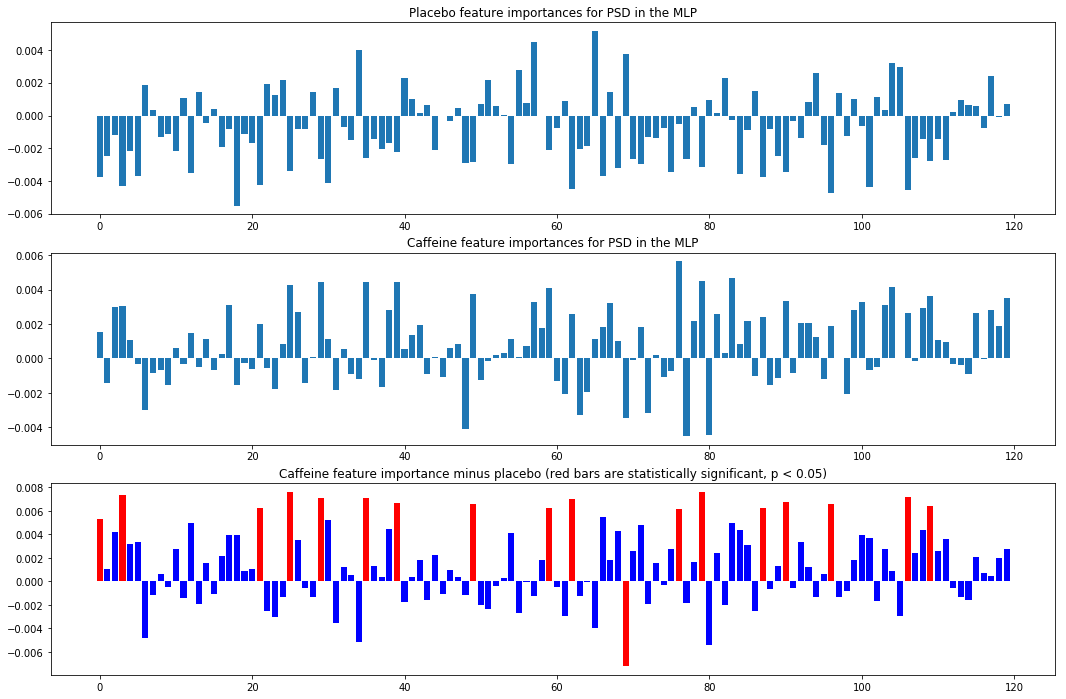

In [90]:
plt.figure(figsize=(18, 12))

plt.subplot(3, 1, 1)
plt.title('Placebo feature importances for PSD in the MLP')
plt.bar(np.arange(120), importances[0].mean(axis=0))#, yerr=importances[0].std(axis=0))

plt.subplot(3, 1, 2)
plt.title('Caffeine feature importances for PSD in the MLP')
plt.bar(np.arange(120), importances[1].mean(axis=0))#, yerr=importances[1].std(axis=0))

plt.subplot(3, 1, 3)
plt.title(f'Caffeine feature importance minus placebo (red bars are statistically significant, p < {p})')
bar_colors = np.array(['b'] * importances[0].shape[1])
bar_colors[p_values < p] = 'r'
plt.bar(np.arange(120), importances[1].mean(axis=0) - importances[0].mean(axis=0), color=bar_colors)

plt.show()

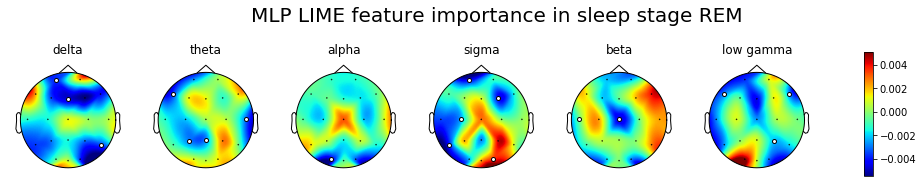

In [92]:
colormap = 'jet'

current = importances[0].mean(axis=0).reshape((20, 6))
p_values_reshaped = p_values.reshape((20, 6))
vmin = current.min()
vmax = current.max()

plt.figure(figsize=(18, 7))
plt.suptitle(f'MLP LIME feature importance in sleep stage REM', y=0.75, fontsize=20)

axes = []
for i, band in enumerate(BANDS):
    ax = plt.subplot(1, 6, i + 1)
    axes.append(ax)
    plt.title(band)
    mask = p_values_reshaped[:,i] < p
    viz.plot_topomap(current[:,i], sensor_pos, cmap=colormap, vmin=vmin, vmax=vmax, mask=mask, contours=False, show=False)

norm = colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=axes, shrink=0.3, aspect=15)
plt.show()

In [22]:
num_runs = 300
scores = {}
for stage, mlp in mlps.items():
    scores[stage] = np.zeros(120)
    for _ in range(num_runs):
        for i, mask in enumerate(np.eye(x_test[stage].shape[1]).astype(np.bool)):
            x_pert = x_test[stage].copy()
            x_pert[:,mask] = np.random.normal()
            scores[stage][i] += mlp.score(x_pert, y_test[stage])
    scores[stage] /= num_runs

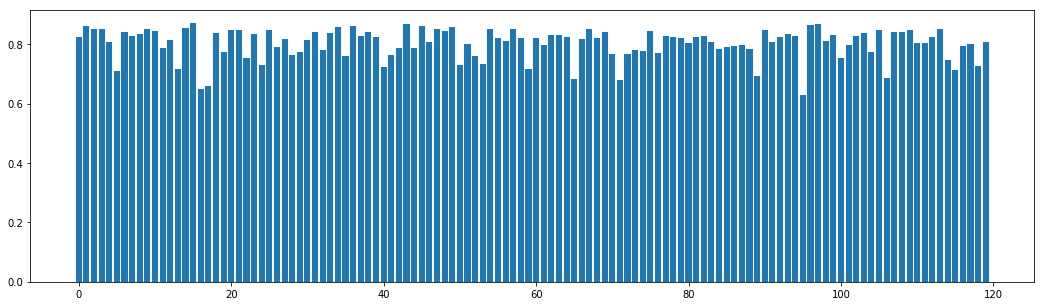

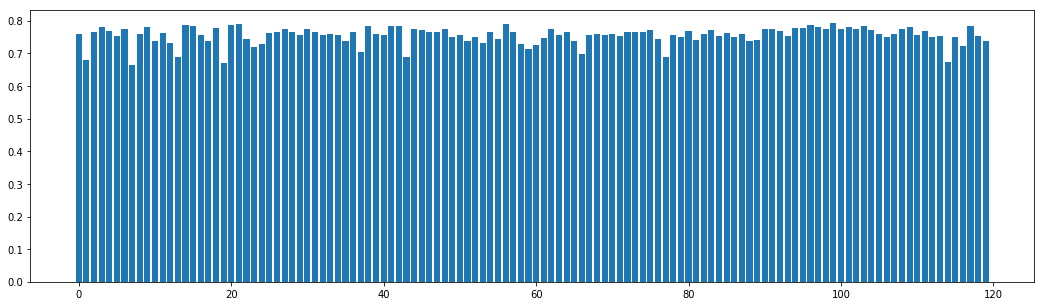

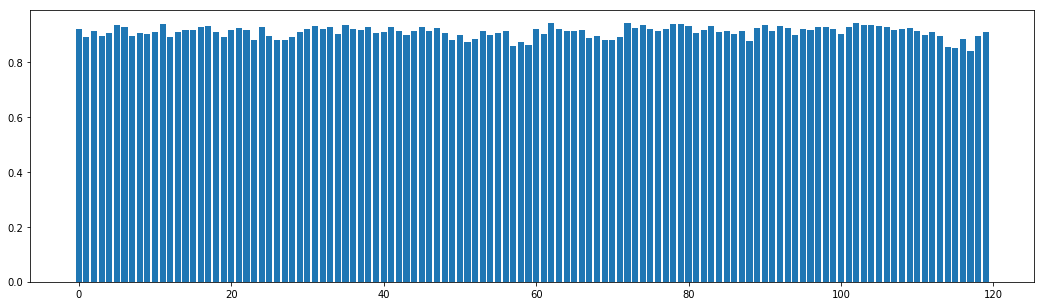

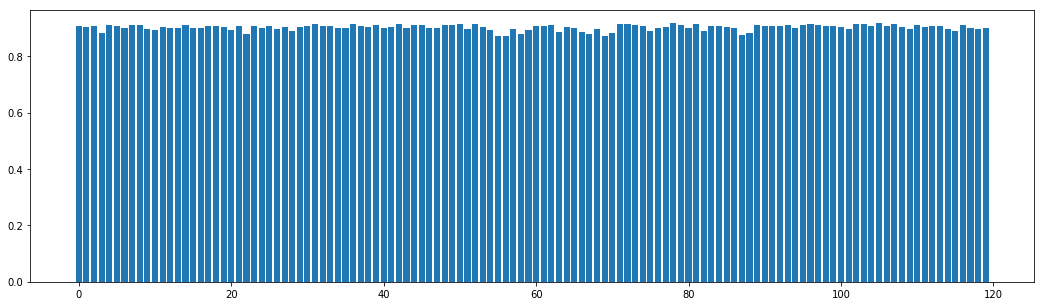

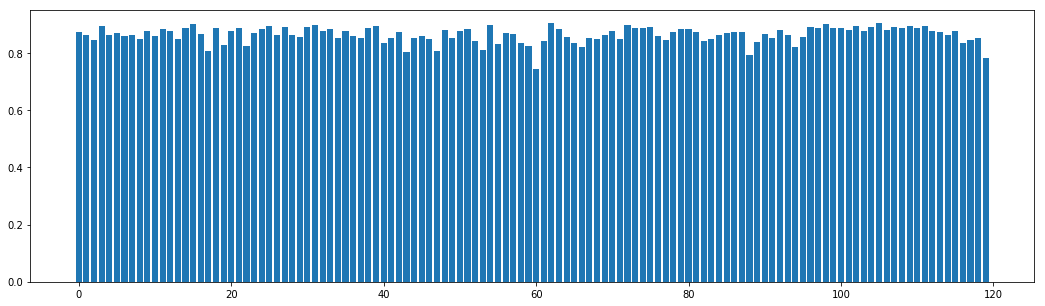

In [23]:
for stage in STAGES:
    plt.figure(figsize=(18, 5))
    plt.bar(np.arange(120), scores[stage])
    plt.show()

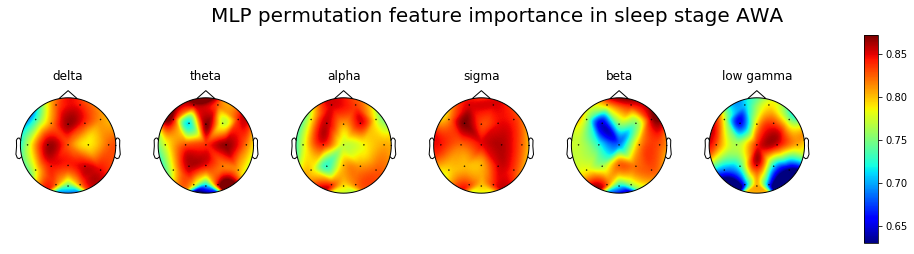

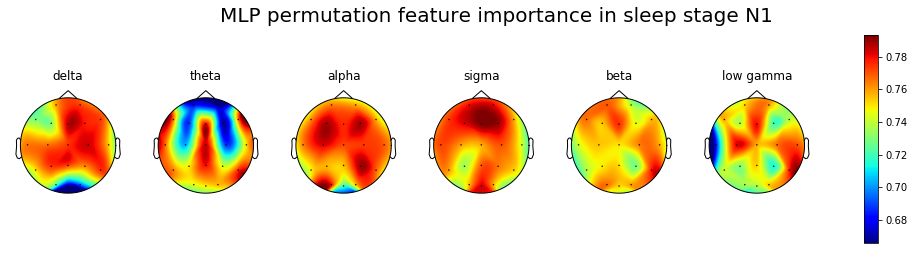

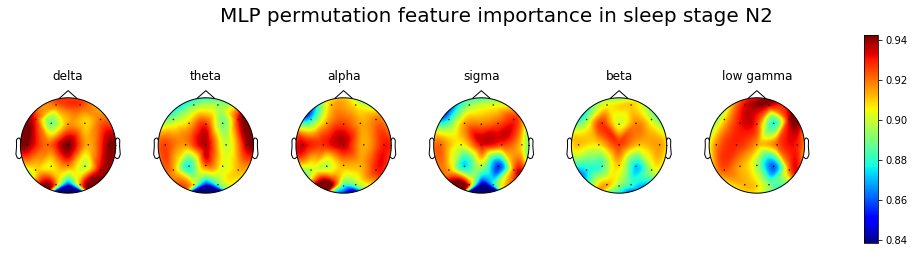

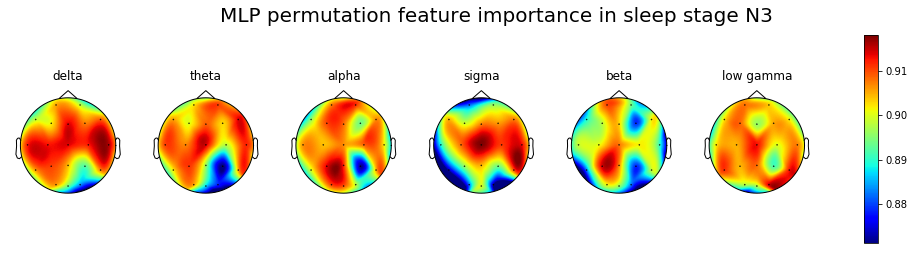

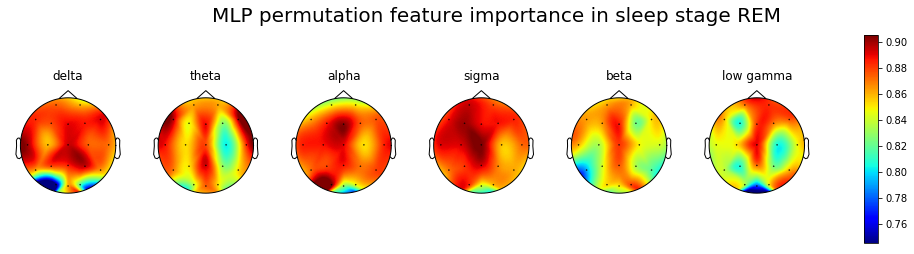

In [93]:
colormap = 'jet'

for stage in STAGES:
    current = scores[stage].reshape((20, 6))
    vmin = current.min()
    vmax = current.max()
    
    plt.figure(figsize=(18, 7))
    plt.suptitle(f'MLP permutation feature importance in sleep stage {stage}', y=0.8, fontsize=20)
    
    axes = []
    for i, band in enumerate(BANDS):
        ax = plt.subplot(1, 6, i + 1)
        axes.append(ax)
        plt.title(band)
        viz.plot_topomap(current[:,i], sensor_pos, cmap=colormap, vmin=vmin, vmax=vmax, contours=False, show=False)
    
    norm = colors.Normalize(vmin=vmin,vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=axes, shrink=0.5, aspect=15)
    plt.show()